In [125]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cvxopt
from cvxopt import matrix
import time
from datetime import datetime

In [126]:
all = 11 # 11 代表十一支產業代表指數
num = all - 1 # 11 - 1 其他代表十支產業代表指數
# define function
def price(all_fund_price, all_index_price, number): # number代表第幾支基金
    other = list(range(all)) 
    fund_price = np.zeros((len(all_fund_price), 1))
    for i in range (len(all_fund_price)):
        fund_price[i] = all_fund_price.iloc[i, number]
    index_price = np.zeros((len(all_fund_price) , num))
    if number-1 in other: other.remove(number-1) # 把我們想要組合出的基金刪掉
    for i in range (len(all_fund_price)):
        for k,j in enumerate(other):
            index_price[i , k] = all_index_price.iloc[i , j]
    for i in range (len(fund_price)):
        if (i != len(fund_price) - 1):
            # 以log計算return => 跌加起來就可以計算一段時間的報酬
            fund_price[i] = math.log((fund_price[i + 1] / fund_price[i]) , 10) 
    for i in range (len(index_price)):
        for j in range (index_price.shape[1]):
            if (i != len(index_price) - 1):
                index_price[i , j] = math.log((index_price[i + 1 , j] / index_price[i , j]) , 10)
    
    fund_price = np.delete(fund_price, [(len(all_fund_price)-1)], axis = 0)
    index_price = np.delete(index_price, [(len(all_fund_price)-1)], axis = 0)
    return fund_price, index_price

def ls(fund_price, index_price):
    #Use Least Squares Method without any constraint.
    indexT = index_price.T #index return的轉置矩陣
    weight = np.dot(np.dot(np.linalg.inv(np.dot(indexT , index_price)), indexT), fund_price)
    return weight

def qp1(fund_price, index_price):
    #Use Quadratic Programming Method without any constraint.
    #裡面的 cvxopt.solvers.qp(P,q,G,h,A,b) 二次規劃求解是欲解出[(1/2)* x * P * x'+ q' * x]的最小值
    indexT = index_price.T #index return的轉置矩陣
    P = np.asmatrix(np.dot(indexT , index_price))
    # 代表 Pi 總和，代表index 跟 indexT的內積
    q = np.asmatrix(np.dot(indexT , fund_price))
    # 代表 qi 總和 ，代表fund 跟 indexT的內積
    P = matrix(P*2) #10*1 matrix p
    q = matrix(q*(-2)) #10*1 vector q
    G = matrix(np.asmatrix((-1)*np.zeros([num,num])))
    h = matrix(np.asmatrix(np.zeros([num,1])))
    #程式裡的限制式為G*x <= h,x為權重 Ｇ為0 h為0 代表權重可為任何數(無限制)
    A = matrix(np.asmatrix(np.zeros([1,num])))
    b = matrix([0.])
    #程式裡的限制式為A*x = b,x為權重 A為值均為0的1*10矩陣 b為0 代表權重和可為任何數(無限制)
    # weight = cvxopt.solvers.qp(P,q,G,h,A,b)
    weight = cvxopt.solvers.qp(P,q,G,h)
    return weight['x']

def qp2(fund_price, index_price):
    #Use Quadratic Programming Method and let the sum of weight equals 1.
    #裡面的 cvxopt.solvers.qp(P,q,G,h,A,b) 二次規劃求解是欲解出[(1/2)* x * P * x'+ q' * x]的最小值
    indexT = index_price.T #index return的轉置矩陣
    P = np.asmatrix(np.dot(indexT , index_price))
    # 代表 Pi 總和，代表index 跟 indexT的內積
    q = np.asmatrix(np.dot(indexT , fund_price))
    # 代表 qi 總和 ，代表fund 跟 indexT的內積
    P = matrix(P*2) #10*10 matrix p
    q = matrix(q*(-2)) #10*1 vector q
    G = matrix(np.asmatrix((-1)*np.zeros([num,num])))
    h = matrix(np.asmatrix(np.zeros([num,1])))
    #程式裡的限制式為G*x <= h,x為權重 Ｇ為0 h為0 代表權重可為任何數(無限制)
    A = matrix(np.asmatrix(np.ones([1,num])))
    b = matrix([1.])
    #程式裡的限制式為A*x = b,x為權重 A為值均為1的1*10矩陣 b為1 代表權重和為一
    weight = cvxopt.solvers.qp(P,q,G,h,A,b)
    return weight['x']

def qp3(fund_price, index_price):
    #Use Quadratic Programming Method and let the sum of weight is equal to 1 
    #and the weight of all constituent stocks are greater or equal to 0.
    #裡面的 cvxopt.solvers.qp(P,q,G,h,A,b) 二次規劃求解是欲解出[(1/2)* x * P * x'+ q' * x]的最小值
    indexT = index_price.T #index return的轉置矩陣
    P = np.asmatrix(np.dot(indexT , index_price))
    # 代表 Pi 總和，代表index 跟 indexT的內積
    q = np.asmatrix(np.dot(indexT , fund_price))
    # 代表 qi 總和 ，代表fund 跟 indexT的內積
    P = matrix(P*2) #10*10 matrix p
    q = matrix(q*(-2)) #10*1 vector q
    G = matrix(np.asmatrix((-1)*np.eye(num)))
    h = matrix(np.asmatrix(np.zeros([num,1])))
    #程式裡的限制式為G*x <= h,x為權重 Ｇ為-1 h為0 代表權重非負
    A = matrix(np.asmatrix(np.ones([1,num])))
    b = matrix([1.])
    #程式裡的限制式為A*x = b,x為權重 A為值均為1的1*10矩陣 b為1 代表權重和為一
    weight = cvxopt.solvers.qp(P,q,G,h,A,b)
    return weight['x']

def qp4(fund_price, index_price):
    # Use Quadratic Programming Method and let the sum of weight is equal to 1 
    # and the weight of all constituent stocks are greater or equal to 0 and less than or equal to 0.5.
    indexT = index_price.T
    P = np.asmatrix(np.dot(indexT , index_price))
    q = np.asmatrix(np.dot(indexT , fund_price))
    P = matrix(P*2)
    q = matrix(q*(-2))
    G = matrix(np.concatenate((-np.eye(num), np.eye(num)), axis=0))  # add an additional constraint
    h = matrix(np.concatenate((np.zeros(num), 0.5 * np.ones(num)), axis=0))  # the upper limit is 0.5
    A = matrix(np.asmatrix(np.ones([1, num])))
    b = matrix([1.])
    weight = cvxopt.solvers.qp(P, q, G, h, A, b)
    return weight['x']
    
def tracking_price(index_return, fund_price, weight, number):
    tracking_return = np.dot(index_return , weight)
    fund_tracking = np.zeros((len(fund_price) , 1))
    fund_tracking[0] = fund_price.iloc[0, number]
    for i in range(len(tracking_return)):
        return_rate = 10 ** tracking_return[i] #預估的基金報酬率
        fund_tracking[i + 1] = fund_tracking[i] * return_rate
    return fund_tracking, tracking_return

def R_Square(predict, gt):
    gt_mean = np.mean(gt)
    sse = 0
    sst = 0
    for i in range(len(predict)):
        sse += (predict[i] - gt[i])**2
        sst += (gt[i] - gt_mean)**2
    return (1-sse/sst)

def Error(predict, gt):
    return_predict = np.zeros(len(predict)-1)
    return_gt = np.zeros(len(predict)-1)
    for i in range(len(predict)-1):
        return_predict[i] = math.log((predict[i+1]/predict[i]))
        return_gt[i] = math.log((gt[i+1]/gt[i]))
    difference = return_gt - return_predict
    return np.mean(difference), np.std(difference), np.linalg.norm(difference), np.mean(abs(difference)), np.mean(difference**2)

In [128]:
import yfinance as yf
symbols_list = ['^GSPC',"AAPL", "MSFT", "AMZN", "JNJ", "JPM", "PG", "XOM", "DIS", "V", "KO"]
start_date = '2017-01-01'
end_date = '2020-06-01'
all_fund_price = yf.download(symbols_list, start_date, end_date)['Close']
all_fund_price.reset_index(inplace=True)

all_index_price = all_fund_price[symbols_list]
all_index_price.head()

[*********************100%***********************]  11 of 11 completed


,^GSPC,AAPL,MSFT,AMZN,JNJ,JPM,PG,XOM,DIS,V,KO
0,2257.830078,29.037500,62.580002,37.683498,115.839996,87.230003,84.199997,90.889999,106.080002,79.500000,41.799999
1,2270.750000,29.004999,62.299999,37.859001,115.650002,86.910004,84.500000,89.889999,107.440002,80.150002,41.650002
2,2269.000000,29.152500,62.299999,39.022499,116.860001,86.110001,85.059998,88.550003,107.379997,81.089996,41.750000
3,2276.979980,29.477501,62.840000,39.799500,116.300003,86.120003,85.029999,88.500000,108.980003,82.209999,41.740002
4,2268.899902,29.747499,62.639999,39.846001,116.279999,86.180000,84.400002,87.040001,108.360001,81.750000,41.320000


In [129]:
# 基金價格追蹤
number = 1
# 用log取得fund和index的return
fund_return, index_return = price(all_fund_price, all_index_price, number)
#weight = ls(fund_return, index_return)
#weight = qp1(fund_return, index_return)
#weight = qp2(fund_return, index_return)
#weight = qp3(fund_return, index_return)
weight = qp4(fund_return, index_return)
fund_tracking, tracking_return = tracking_price(index_return, all_fund_price, weight, number)

     pcost       dcost       gap    pres   dres
 0: -3.9855e-02 -5.3706e+00  5e+00  3e-16  4e-16
 1: -4.0165e-02 -2.1591e-01  2e-01  1e-16  8e-16
 2: -5.0137e-02 -7.6187e-02  3e-02  2e-16  3e-17
 3: -5.3602e-02 -5.6095e-02  2e-03  2e-16  3e-17
 4: -5.3885e-02 -5.4211e-02  3e-04  2e-16  2e-17
 5: -5.3924e-02 -5.3952e-02  3e-05  2e-16  1e-17
 6: -5.3931e-02 -5.3933e-02  2e-06  2e-16  1e-17
 7: -5.3931e-02 -5.3932e-02  1e-07  2e-16  2e-17
 8: -5.3932e-02 -5.3932e-02  2e-08  1e-16  2e-17
Optimal solution found.


In [130]:
print(f'Weight:\n{weight}')
print(f'Sum:{sum(weight)}')

Weight:
[ 5.00e-01]
[ 1.70e-01]
[ 1.01e-01]
[ 8.72e-04]
[ 4.56e-02]
[ 3.19e-02]
[ 1.63e-02]
[ 2.55e-02]
[ 1.09e-01]
[ 3.31e-07]

Sum:0.9999999999999999


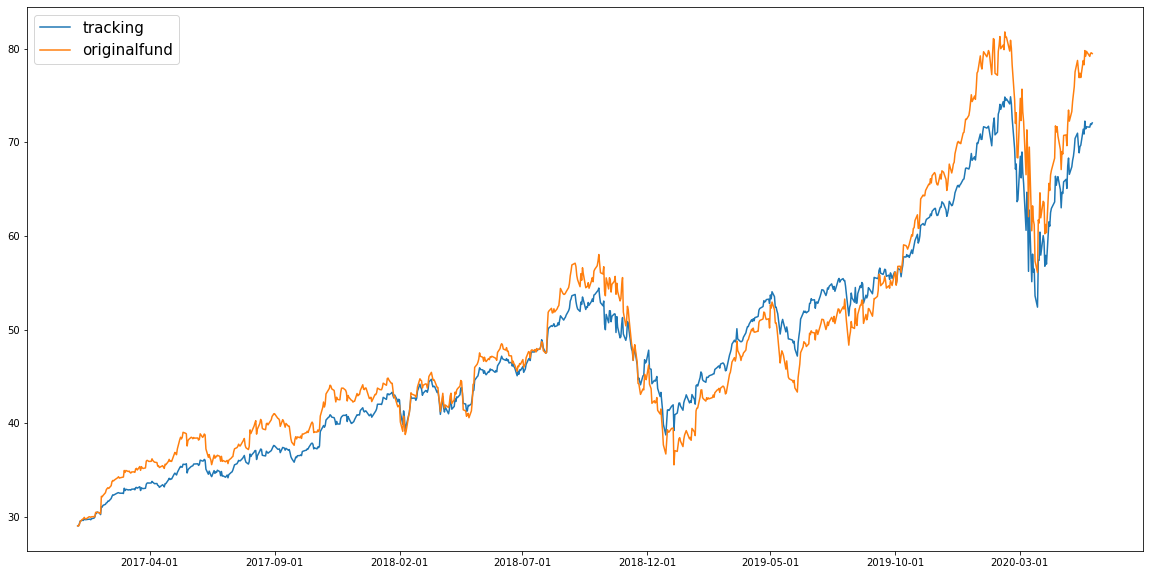

In [131]:
# 價格追蹤結果圖
date = all_fund_price['Date']
date = pd.to_datetime(date) # 轉為轉為datetime的時間資料型態，轉換後可以對時間資料做計算，ex.計算時間差
plt.figure(figsize=(20,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.plot(date , fund_tracking)
plt.plot(date , all_fund_price.iloc[:, number])#[:,i]
plt.legend(['tracking', 'originalfund'] , fontsize = 15)

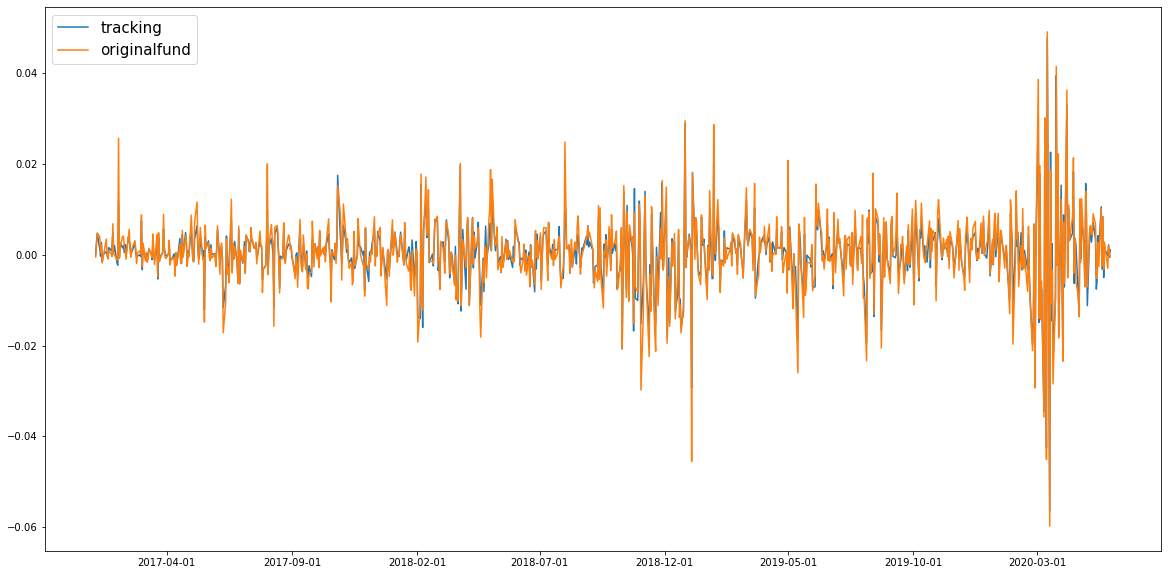

In [132]:
# 報酬追蹤結果圖
date = all_fund_price['Date']
date = pd.to_datetime(date)
date = date.iloc[1:]
plt.figure(figsize=(20,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.plot(date , tracking_return)
plt.plot(date , fund_return)
plt.legend(['tracking', 'originalfund'] , fontsize = 15)

In [133]:
# 各誤差值計算
r_square_error = R_Square(fund_tracking, all_fund_price.iloc[:, number])
print("R_Square :", r_square_error)

td, te, norm_2, MAE, MSE = Error(fund_tracking, all_fund_price.iloc[:, number])
print("Tracking Difference :", td)
print("Tracking Error :", te)
print("2-Norm Error :", norm_2)
print("MAE :", MAE)
print("MSE :", MSE)

R_Square : [0.93697168]
Tracking Difference : 0.00011421195508767807
Tracking Error : 0.005728383143685989
2-Norm Error : 0.16763135042911104
MAE : 0.003948726791090197
MSE : 3.282741781155073e-05


In [150]:
from scipy.stats import norm

def evaluate_performance(fund_tracking, risk_free_rate=0.01):
    # Calculate daily returns from fund tracking prices
    daily_returns = np.diff(fund_tracking.flatten()) / fund_tracking.flatten()[:-1]
    
    # Calculate metrics
    annualized_return = np.mean(daily_returns) * 252
    annualized_volatility = np.std(daily_returns) * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    return annualized_return, annualized_volatility, sharpe_ratio

# Define risk free rate
risk_free_rate = 0.01  # Assuming a risk free rate of 1%

# Evaluate performance
annualized_return, annualized_volatility, sharpe_ratio = evaluate_performance(fund_tracking, risk_free_rate)

print(f"Annualized Return: {annualized_return}")
print(f"Annualized Volatility: {annualized_volatility}")
print(f"Sharpe Ratio: {sharpe_ratio}")

# Create a DataFrame for fund tracking and returns for easier handling
df = pd.DataFrame({
    'Fund_Tracking': fund_tracking.flatten()[:-1],
    'Tracking_Return': tracking_return.flatten()
})

# Calculate Maximum Drawdown
df['Drawdown'] = df['Fund_Tracking'] / df['Fund_Tracking'].cummax() - 1.0
max_drawdown = df['Drawdown'].min()

# Calculate Sortino Ratio
negative_returns = df[df['Tracking_Return'] < 0]['Tracking_Return']
down_stdev = np.sqrt(np.sum(negative_returns**2) / len(negative_returns)) * np.sqrt(252)
sortino_ratio = (annualized_return - risk_free_rate) / down_stdev

print(f"Max Drawdown: {max_drawdown}")
print(f"Sortino Ratio: {sortino_ratio}")

Annualized Return: 0.3008590268115232
Annualized Volatility: 0.2568203574063475
Sharpe Ratio: 1.1325388288877696
Max Drawdown: -0.3002183537156621
Sortino Ratio: 2.369914919783081


In [160]:
def calculate_jensens_alpha(fund_tracking, market_prices, risk_free_rate=0.01):
    # Calculate daily and market return
    daily_returns = np.diff(fund_tracking.flatten()) / fund_tracking.flatten()[:-1]
    market_returns = np.log(market_prices / market_prices.shift(1))
    
    # Subtract the risk-free rate from the returns
    excess_portfolio_return = daily_returns - risk_free_rate
    excess_market_return = (market_returns - risk_free_rate)[1:]
    print(excess_portfolio_return.shape, excess_market_return.shape)

    # Calculate the beta of the portfolio by regressing portfolio returns on market returns
    beta, alpha = np.polyfit(excess_market_return, excess_portfolio_return, deg=1)

    # Calculate the expected portfolio return using CAPM
    expected_portfolio_return = risk_free_rate + beta * excess_market_return

    # Jensen's alpha is the average difference between the actual and expected portfolio returns
    jensens_alpha = np.mean(daily_returns - expected_portfolio_return)

    return jensens_alpha

In [161]:
print(f'Jensens Alpha:{calculate_jensens_alpha(fund_tracking, all_fund_price.iloc[:, number], risk_free_rate)}')

(856,) (856,)
Jensens Alpha:-0.0016365512126787973
